# Analysis of Antarctic Sea Level: Monthly Mean

![Antarctica Sea Level](https://e360.yale.edu/assets/site/Antarctica_ChristopherMichelFlickr.jpg)







Sea Level measurement in the Antarctic region is of critical importance for understanding and monitoring global climate changes. Antarctica, with its massive ice caps, is one of the planet's primary freshwater reservoirs. The rise or decrise of sea level in this region is a direct indicator of changes in the size of glaciers and ice shelves.

Measuring sea level anomalies is crucial because they provide specific information about the phenomena directly influencing sea level. For example, positive anomalies may indicate water accumulation due to glacier melt. These measurements are essential for monitoring ocean dynamics, predicting extreme weather events, and understanding the impact of climate change on global coastlines and marine ecosystems. Accurate and continuous research in this region is thus vital to address the challenges of climate change and safeguard the global balance of marine ecosystems.

In this article, we explore monthly data in time range 1993-2020, focusing on monthly levels anomalies of Antarctic sea.

Note: The data and trends presented in this article are based on information available up until December 2020. Subsequent developments may not be included in the analysis.

In [31]:
!pip install ipyleaflet ipywidgets matplotlib pandas
%reload_ext autoreload
%autoreload 2

In [32]:
import requests
import xml.etree.ElementTree as ET
import calendar
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime, timedelta, timezone
from traitlets import Unicode
from ipyleaflet import (
    Map,
    Marker,
    basemaps,
    projections,
    WMSLayer,
    Popup,
    Icon,
    AwesomeIcon
)
from ipywidgets import (
    Play,
    jslink,
    IntSlider,
    HBox,
    Text,
    Layout,
    Output,
    VBox,
    HTML
)
from IPython.display import display, clear_output

In [33]:
# Configurations
ERDDAP_SLA_URL = 'https://prod-erddap.emodnet-physics.eu/erddap/griddap/EMODNET_CMCC_ASVL_DUAC_GLO_MONTHLYMAPS_v2022.json?sla'

WMS_URL = 'https://prod-erddap.emodnet-physics.eu/ncWMS/wms'
WMS_LAYER = 'EMODNET_CMCC_ASVL_DUAC_GLO_MONTHLYMAPS_v2022/sla'
GET_CAPABILITIES_URL = f"{WMS_URL}?SERVICE=WMS&REQUEST=GetCapabilities&VERSION=1.3.0&DATASET={WMS_LAYER}"

TIME_RANGE = '[(1993-01-16T00:00:00Z):1:(2020-12-16T00:00:00Z)]'

EPSG3031 = dict(
    name='EPSG:3031',
    custom=True,
    proj4def="""+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1
        +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs""",
    bounds=[[-3500000,-3500000],[3500000,3500000]]
)

GEOSERVER_SOOS_URL = 'https://gs1webapps.emodnet-physics.eu/geoserver/wfs?request=getfeature&service=wfs&version=2.0.0&srsName=EPSG:3031&typeName=SOOS:dat_platformmapcache&outputFormat=application%2Fjson'
SOOS_LINK = 'https://map.emodnet-physics.eu/platformpage/?source=cp&platformcode='

In [34]:
# Retrieving observation datetimes
get_capabilities = requests.get(GET_CAPABILITIES_URL)

if get_capabilities.status_code == 200:
  root = ET.fromstring(get_capabilities.content)
  for elem in root.findall(".//{http://www.opengis.net/wms}Dimension"):
    if 'name' in elem.attrib and elem.attrib['name'] == 'time':
      obs_dates = elem.text.strip().split(',')
else:
  print("ERROR:", get_capabilities.status_code)

In [35]:
# Antarctic Map
m = Map(
    center=(-90, 0),
    zoom=2,
    min_zoom=2,
    basemap=basemaps.Esri.AntarcticBasemap,
    crs=projections.EPSG3031.ESRIBasemap,
    layout=Layout(width='500px', height='450px')
)

m.layout.width = '50%'

class TimeWMSLayer(WMSLayer):
    time = Unicode('').tag(sync=True, o=True)

wms = TimeWMSLayer(
    url=WMS_URL,
    layers=WMS_LAYER,
    attribution="EMODNET Data",
    format='image/png',
    transparent=True,
    styles="default-scalar/x-Rainbow",
    colorscalerange=(-1, 1),
    crs=EPSG3031,
    #bounds = [(-3500000,-3500000), (3500000,3500000)]
    bounds = [(-90,-180), (0,180)]
)

m.add_layer(wms)
#m.fit_bounds([[-3599207.53,-3533134.03],[3599207.53,3533134.03]])

Below you can see a map of the Antarctic area, by clicking on the play button you can view the data over the period of time considered directly on the map, you can still choose a specific month by moving the slider. Furthermore it is possible to view the data, grouped by season, for each single year on a specific graph by clicking on a specific point on the map

In [36]:
# DateTime slider control
def updating_values(value):
  selected_time = obs_dates[(value.new)-1]
  time_descr.value = datetime.strptime(selected_time, "%Y-%m-%dT%H:%M:%S.%fZ").strftime("%B %Y")
  wms.time = selected_time

play = Play(
    value=len(obs_dates),
    min=1,
    max=len(obs_dates),
    step=1,
    interval=2000,
    description='',
    disabled=False
)
slider = IntSlider(min=1, max=len(obs_dates), readout = False)
time_descr = Text(value= datetime.strptime(obs_dates[0], "%Y-%m-%dT%H:%M:%S.%fZ").strftime("%B %Y") , description='', layout=Layout(width='180px'), disabled=True)

jslink((play, 'value'), (slider, 'value'))

slider.observe(updating_values, names='value')

graph_area = Output()
graph_area.layout.width = '50%'

VBox([HBox([play, slider, time_descr]), HBox([m, graph_area])])


HTML(value='\n    <style>\n    .loader {\n        border: 8px solid #f3f3f3;\n        border-top: 8px solid #3…

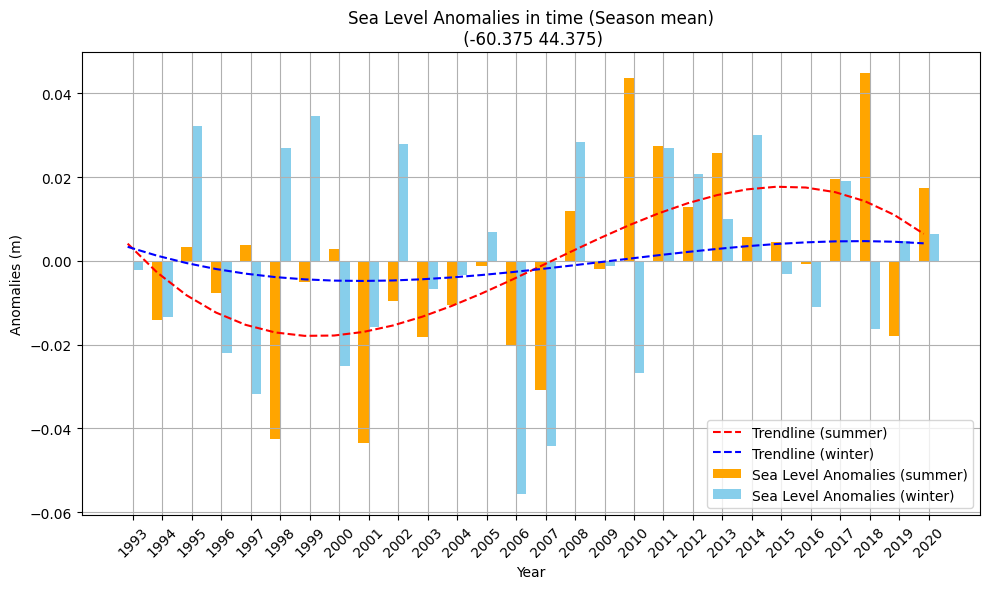

In [37]:
# Map click functions:
# Show DataTable
def show_dataTable(table, df):

  # Remove previous table
  table.clear_output()

  with table:
    display(df)

# Show loading...
def show_loading_animation():
    loading_html = """
    <style>
    .loader {
        border: 8px solid #f3f3f3;
        border-top: 8px solid #3498db;
        border-radius: 50%;
        width: 50px;
        height: 50px;
        animation: spin 1s linear infinite;
    }

    @keyframes spin {
        0% { transform: rotate(0deg); }
        100% { transform: rotate(360deg); }
    }
    </style>
    <div class="loader"></div>
    """
    graph_area.clear_output()
    with graph_area:
      display(HTML(loading_html))

# Making a data graph
def generate_sealevel_anomalies_data_plot(latlon):
  show_loading_animation()
  lat = latlon[0]
  lon = latlon[1]
  url = ERDDAP_SLA_URL + TIME_RANGE + f'[({lat}):1:({lat})][({lon}):1:({lon})]'

  try:
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()

    global summer_data
    global winter_data
    df_oct_to_mar = pd.DataFrame()
    df_apr_to_sep = pd.DataFrame()

    column_names = data['table']['columnNames']
    rows = data['table']['rows']
    df = pd.DataFrame(rows, columns=column_names)

    df['timestamp'] = pd.to_datetime(df['time'])
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year

    df_oct_to_mar = df[df['month'].isin([10, 11, 12, 1, 2, 3])].reset_index()
    df_apr_to_sep = df[df['month'].isin([4, 5, 6, 7, 8, 9])].reset_index()

    mean_sla_oct_to_mar = df_oct_to_mar.groupby('year')['sla'].mean().reset_index()
    mean_sla_apr_to_sep = df_apr_to_sep.groupby('year')['sla'].mean().reset_index()

    #mean_sla_oct_to_mar = mean_sla_apr_to_sep.drop(columns=['year', 'month', 'timestamp', 'index', 'latitude', 'longitude'])
    #mean_sla_apr_to_sep = mean_sla_apr_to_sep.drop(columns=['year', 'month', 'timestamp', 'index', 'latitude', 'longitude'])

    show_dataTable(summer_data, mean_sla_oct_to_mar)
    show_dataTable(winter_data, mean_sla_apr_to_sep)

    # Plot
    plt.figure(figsize=(10, 6))

    # Plotting Bars
    bar_width = 0.35
    x_oct_to_mar = np.arange(len(mean_sla_oct_to_mar))
    x_apr_to_sep = np.arange(len(mean_sla_apr_to_sep))
    bars_oct_to_mar = plt.bar(x_oct_to_mar, mean_sla_oct_to_mar['sla'], width=bar_width, color='orange', label='Sea Level Anomalies (summer)')
    bars_apr_to_sep = plt.bar(x_apr_to_sep + bar_width, mean_sla_apr_to_sep['sla'], width=bar_width, color='skyblue', label='Sea Level Anomalies (winter)')

    # Trend Line
    z_oct_to_mar = np.polyfit(x_oct_to_mar, mean_sla_oct_to_mar['sla'], 3)
    p_oct_to_mar = np.poly1d(z_oct_to_mar)
    plt.plot(x_oct_to_mar, p_oct_to_mar(x_oct_to_mar), color='red', linestyle='--', label='Trendline (summer)')

    z_apr_to_sep = np.polyfit(x_apr_to_sep, mean_sla_apr_to_sep['sla'], 3)
    p_apr_to_sep = np.poly1d(z_apr_to_sep)
    plt.plot(x_apr_to_sep, p_apr_to_sep(x_apr_to_sep), color='blue', linestyle='--', label='Trendline (winter)')

    plt.xlabel('Year')
    plt.ylabel('Anomalies (m)')
    plt.title(f"Sea Level Anomalies in time (Season mean)\n ({df['latitude'][0]} {df['longitude'][0]})")
    plt.legend()
    plt.xticks(x_oct_to_mar + bar_width / 2, mean_sla_oct_to_mar['year'], rotation=45)
    plt.grid(True)
    plt.tight_layout()

    graph_area.clear_output()

    plt.show()

  except:
    print('No Data Available...')

random_point = (-60.375, 44.375)
marker = Marker(location=random_point)
# Adding the marker on map
m.add_layer(marker)

# Generate a new graph
with graph_area:
  generate_sealevel_anomalies_data_plot(random_point)

And here you can see all the values splitted into two tables: the first one referred to summer data while in the second one you can check winter data

In [38]:
summer_data = Output()
winter_data = Output()

HBox([summer_data, winter_data])

In [39]:
def onChangeLatlon(**kwargs):
  global graph_area
  global m
  latlon = kwargs.get('coordinates')
  if kwargs.get('type') == 'click':

    # Eliminare eventuali marker precedenti
    for layer in m.layers:
        if isinstance(layer, Marker):
            m.remove_layer(layer)

    marker = Marker(location=latlon)
    m.add_layer(marker)

    # Remove previous graph
    graph_area.clear_output()

    # Genera a new graph
    with graph_area:
      generate_sealevel_anomalies_data_plot(latlon)

m.on_interaction(onChangeLatlon)

Below positions and data from tide gauge platforms around the antarctic area:

In [40]:
def format_date(date_str):
    # Funzione per convertire il formato della data
    date_time = datetime.strptime(date_str, '%Y-%m-%dT%H:%M:%SZ')
    # Aggiungi il fuso orario GMT+1
    date_time = date_time.replace(tzinfo=timezone.utc).astimezone(timezone(timedelta(hours=1)))
    formatted_date = date_time.strftime('%d/%m/%Y %H:%M GMT%z')
    return formatted_date

geoserver_filter = "&cql_filter=(platformType IN ('TG')) AND (lastDateObservationDT>='1993-01-16T00:00:00.000Z')"
pl_url = GEOSERVER_SOOS_URL + geoserver_filter

try:
  response = requests.get(pl_url)
  response.raise_for_status()
  data = response.json()

  m2 = Map(
      basemap=basemaps.Esri.AntarcticBasemap,
      crs=projections.EPSG3031.ESRIBasemap,
      center=(-90, 0),
      zoom=2,
      min_zoom=2,
      layout=Layout(height='600px'),
      close_on_escape_key=False
  )

  data_marker = data['features']
  for data in data_marker:
    position = (data['properties']['latitude'], data['properties']['longitude'])

    marker = Marker(location=position)

    html = HTML()
    infos = f'''<b>Platform Code:</b> {data['properties']['platformcode']}<br/>
    <b>Platform Name:</b> {data['properties']['platformName']}<br/>
    <b>Lat:</b> {data['properties']['latitude']} <b>Lon:</b> {data['properties']['longitude']}<br/>
    <b>Source:</b> {data['properties']['source']}<br/>
    <b>DataOwner:</b> {data['properties']['dataOwner']}<br/>
    <b>Last Observation:</b> {format_date(data['properties']['lastDateObservation'])}<br/>
    <a href='{SOOS_LINK + data['properties']['platformcode']}' target='_blank'>View data</a>'''
    html.value = infos

    popup = Popup(
        location=position,
        child=html,
        close_button=True,
        auto_close=False,
    )
    marker.popup = popup

    m2.add_layer(marker)
except:
  print('No Data Available...')

m2

Map(center=[-90, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…